In [103]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from quant.Classification import Classification
from quant.factor import get_factors, get_label
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

np.set_printoptions(precision=4, suppress=True)

import warnings
warnings.filterwarnings('ignore')

### How to categorise small near-zero returns

We note that MSE and $R^2$ score is difference when the ratio changes, so the experiment will focus on the relation between ratio and directors.

We set the sign ratio from 0.9 to 1.15, increasing by 0.0005 each step. Several indicators were counted in the experement.

In [104]:
klines_1h_file = 'data/futures_klines_1h_BTCUSDT_20200101_20220430.zip'
kline_1h_df = pd.read_csv(klines_1h_file, index_col=0, parse_dates=True)
kline_1h_factors = get_factors(kline_1h_df, sign_ratio=1)

In [105]:
X = kline_1h_factors.drop(['Price', 'Returns', 'CumReturns', 'Log_Returns', 'Returns_Ratio', 'Sign'], axis=1)
y = kline_1h_factors['Sign']
X.shape, y.shape

((20217, 18), (20217,))

In [106]:
scores = pd.DataFrame(columns=['ratio', 'mse', 'rmse', 'r2train', 'r2test', 'positive count', 'negative count'], index=[])

for i in tqdm(np.arange(0.9, 1.15, 0.0005)):
    label = get_label(kline_1h_factors['Price'], i)

    label_positive = sum(1==label)
    label_negative = sum(0==label)

    decision_tree = Classification(X, label)
    decision_tree.fit_predict(MinMaxScaler(), DecisionTreeClassifier(random_state=64))
    decision_tree_mse, decision_tree_rmse, decision_tree_r2train, decision_tree_r2test = decision_tree.eval_metrics()
    index = scores.index.size
    scores.loc[index] = [i, decision_tree_mse, decision_tree_rmse, decision_tree_r2train, decision_tree_r2test, label_positive, label_negative]

scores.shape

100%|██████████| 500/500 [01:57<00:00,  4.25it/s]


(500, 7)

In [107]:
scores[190:210]

,ratio,mse,rmse,r2train,r2test,positive count,negative count
190,0.9950,0.2663,0.5161,1.0000,0.7337,17019.0000,3198.0000
191,0.9955,0.2757,0.5251,1.0000,0.7243,16616.0000,3601.0000
192,0.9960,0.3145,0.5608,1.0000,0.6855,16213.0000,4004.0000
193,0.9965,0.3464,0.5886,1.0000,0.6536,15751.0000,4466.0000
194,0.9970,0.3628,0.6023,1.0000,0.6372,15202.0000,5015.0000
195,0.9975,0.3981,0.6310,1.0000,0.6019,14586.0000,5631.0000
196,0.9980,0.4305,0.6561,1.0000,0.5695,13917.0000,6300.0000
197,0.9985,0.4481,0.6694,1.0000,0.5519,13082.0000,7135.0000
198,0.9990,0.4661,0.6827,1.0000,0.5339,12182.0000,8035.0000
199,0.9995,0.4869,0.6978,1.0000,0.5131,11295.0000,8922.0000


<AxesSubplot:xlabel='ratio'>

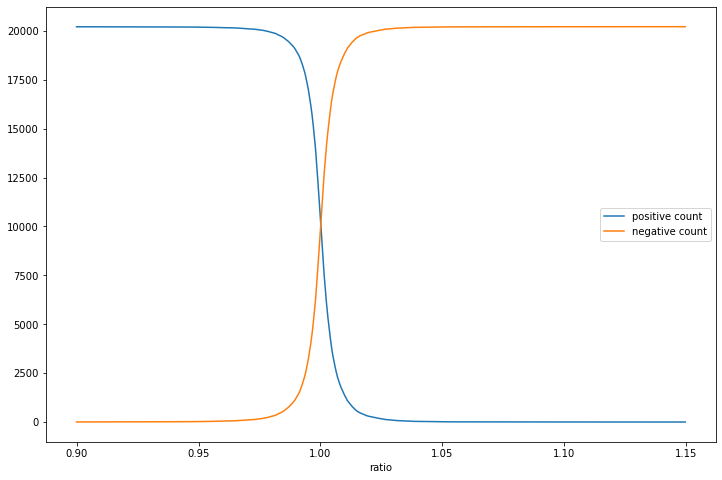

In [108]:
scores.plot(x='ratio', y=['positive count', 'negative count'], figsize=(12, 8))

<AxesSubplot:xlabel='ratio'>

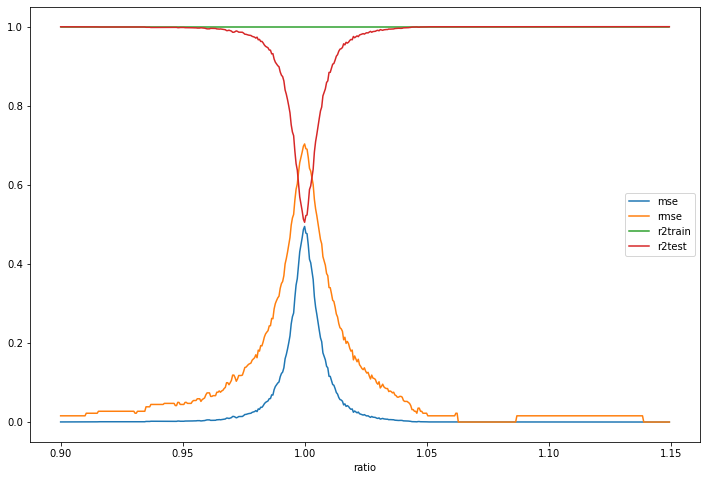

In [109]:
scores.plot(x='ratio', y=['mse', 'rmse', 'r2train', 'r2test'], figsize=(12, 8))

In [110]:
# Result

row_0995 = scores.loc[np.isclose(scores['ratio'], 0.995)]
row_09995 = scores.loc[np.isclose(scores['ratio'], 0.9995)]
row_10000 = scores.loc[np.isclose(scores['ratio'], 1.0000)]
row_10005 = scores.loc[np.isclose(scores['ratio'], 1.0005)]
row_1005 = scores.loc[np.isclose(scores['ratio'], 1.005)]

pca_result = pd.DataFrame()
pca_result = pca_result.append(row_0995)
pca_result = pca_result.append(row_09995)
pca_result = pca_result.append(row_10000)
pca_result = pca_result.append(row_10005)
pca_result = pca_result.append(row_1005)

pca_result.columns = ['Ratio', 'MSE', 'RMSE', 'R2Train', 'R2Test', 'Positive', 'Negative']
pca_result.reset_index(drop=True, inplace=True)
print(pca_result.to_latex(index=False))
pca_result

\begin{tabular}{rrrrrrr}
\toprule
 Ratio &    MSE &   RMSE &  R2Train &  R2Test &   Positive &   Negative \\
\midrule
0.9950 & 0.2663 & 0.5161 &   1.0000 &  0.7337 & 17019.0000 &  3198.0000 \\
0.9995 & 0.4869 & 0.6978 &   1.0000 &  0.5131 & 11295.0000 &  8922.0000 \\
1.0000 & 0.4948 & 0.7034 &   1.0000 &  0.5052 & 10346.0000 &  9871.0000 \\
1.0005 & 0.4780 & 0.6914 &   1.0000 &  0.5220 &  9385.0000 & 10832.0000 \\
1.0050 & 0.2725 & 0.5220 &   1.0000 &  0.7275 &  3447.0000 & 16770.0000 \\
\bottomrule
\end{tabular}



,Ratio,MSE,RMSE,R2Train,R2Test,Positive,Negative
0,0.9950,0.2663,0.5161,1.0000,0.7337,17019.0000,3198.0000
1,0.9995,0.4869,0.6978,1.0000,0.5131,11295.0000,8922.0000
2,1.0000,0.4948,0.7034,1.0000,0.5052,10346.0000,9871.0000
3,1.0005,0.4780,0.6914,1.0000,0.5220,9385.0000,10832.0000
4,1.0050,0.2725,0.5220,1.0000,0.7275,3447.0000,16770.0000


### Conclusion

Considering the balance of the sign distribution, 1.0 ratio is the best choice for the experiment. If the ratio is changed to be unbalanced, the indicators will be biased to one direction.